# PropBank in NLTK

(C) 2019-2024 by [Damir Cavar](http://damir.cavar.me/)

**Version:** 1.2, January 2024

**License:** [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/) ([CA BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/))

**Prerequisites:**

In [ ]:
!pip install -U nltk

The material in this notebook is based on:
- [The NLKT Howto on Propbank](https://www.nltk.org/howto/propbank.html)
- [The Proposition Bank Website](https://verbs.colorado.edu/~mpalmer/projects/ace.html)
- [The Propbank GitHub repo](https://github.com/propbank/propbank-release)
- [The Google Propbank Archive](https://code.google.com/archive/p/propbank/downloads)

The PropBank Corpus augments the Penn Treebank syntactic trees with predicate-argument annotation. PropBank provides a specific annotation about verbs and arguments for every single tree in the Penn Treebank.

In [32]:
from nltk.corpus import propbank

In [33]:
pb_instances = propbank.instances()
print(pb_instances)

[<PropbankInstance: wsj_0001.mrg, sent 0, word 8>, <PropbankInstance: wsj_0001.mrg, sent 1, word 10>, ...]


Each propbank instance defines the following member variables:
- Location information: fileid, sentnum, wordnum
- Annotator information: tagger
- Inflection information: inflection
- Roleset identifier: roleset
- Verb (aka predicate) location: predicate
- Argument locations and types: arguments

In [34]:
inst = pb_instances[103]

In [35]:
print("File ID:", inst.fileid)

File ID: wsj_0004.mrg


In [36]:
print("Sentence Number:", inst.sentnum)

Sentence Number: 8


In [37]:
print("Word Number:", inst.wordnum)

Word Number: 16


In [7]:
inst.tagger

'gold'

In [8]:
inst.inflection

<PropbankInflection: vp--a>

In [9]:
infl = inst.inflection

In [10]:
infl.form, infl.tense, infl.aspect, infl.person, infl.voice

('v', 'p', '-', '-', 'a')

In [11]:
inst.roleset

'rise.01'

In [12]:
inst.predicate

PropbankTreePointer(16, 0)

In [13]:
inst.arguments

((PropbankTreePointer(0, 2), 'ARG1'),
 (PropbankTreePointer(13, 1), 'ARGM-DIS'),
 (PropbankTreePointer(17, 1), 'ARG4-to'),
 (PropbankTreePointer(20, 1), 'ARG3-from'))

The location of the predicate and of the arguments are encoded using *PropbankTreePointer* objects, as well as *PropbankChainTreePointer* objects and *PropbankSplitTreePointer* objects. A *PropbankTreePointer* consists of a wordnum and a height:

In [14]:
print(inst.predicate.wordnum, inst.predicate.height)

16 0


This identifies the tree constituent that is headed by the word that is the *wordnum*'th token in the sentence, and whose span is found by going *height* nodes up in the tree. This type of pointer is only useful if we also have the corresponding tree structure, since it includes empty elements such as traces in the word number count. The trees for 10% of the standard PropBank Corpus are contained in the *treebank* corpus:

In [15]:
tree = inst.tree

In [16]:
from nltk.corpus import treebank

In [17]:
assert tree == treebank.parsed_sents(inst.fileid)[inst.sentnum]

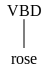

In [19]:
inst.predicate.select(tree)

In [23]:
for (argloc, argid) in inst.arguments:
    print('%-10s %s' % (argid, argloc.select(tree).pformat(500)[:50]))

ARG1       (NP-SBJ (NP (DT The) (NN yield)) (PP (IN on) (NP (
ARGM-DIS   (PP (IN for) (NP (NN example)))
ARG4-to    (PP-DIR (TO to) (NP (CD 8.04) (NN %)))
ARG3-from  (PP-DIR (IN from) (NP (CD 7.90) (NN %)))


Propbank tree pointers can be converted to standard tree locations, which are usually easier to work with, using the treepos() method:

In [38]:
treepos = inst.predicate.treepos(tree)

In [39]:
print (treepos, tree[treepos])

(4, 0) (VBD rose)


In some cases, argument locations will be encoded using PropbankChainTreePointers (for trace chains) or PropbankSplitTreePointers (for discontinuous constituents). Both of these objects contain a single member variable, pieces, containing a list of the constituent pieces. They also define the method select(), which will return a tree containing all the elements of the argument. (A new head node is created, labeled "CHAIN" or "SPLIT", since the argument is not a single constituent in the original tree). Sentence #6 contains an example of an argument that is both discontinuous and contains a chain:

In [26]:
inst = pb_instances[6]

In [27]:
inst.roleset

'expose.01'

In [28]:
argloc, argid = inst.arguments[2]
argloc

<PropbankChainTreePointer: 22:1,24:0,25:1*27:0>

In [29]:
argloc.pieces

[<PropbankSplitTreePointer: 22:1,24:0,25:1>, PropbankTreePointer(27, 0)]

In [30]:
argloc.pieces[0].pieces

[PropbankTreePointer(22, 1),
 PropbankTreePointer(24, 0),
 PropbankTreePointer(25, 1)]

In [31]:
print(argloc.select(inst.tree))

(*CHAIN*
  (*SPLIT* (NP (DT a) (NN group)) (IN of) (NP (NNS workers)))
  (-NONE- *))


The PropBank Corpus also provides access to the frameset files, which define the argument labels used by the annotations, on a per-verb basis. Each frameset file contains one or more predicates, such as 'turn' or 'turn_on', each of which is divided into coarse-grained word senses called rolesets. For each roleset, the frameset file provides descriptions of the argument roles, along with examples.

In [70]:
expose_01 = propbank.roleset('expose.01')

In [71]:
turn_01 = propbank.roleset('turn.01')

In [72]:
print(turn_01)

<Element 'roleset' at 0x7faae977d110>


In [73]:
for role in turn_01.findall("roles/role"):
    print(role.attrib['n'], role.attrib['descr'])

0 turner
1 thing turning
m direction, location


In [74]:
from xml.etree import ElementTree

In [75]:
print(ElementTree.tostring(turn_01.find('example')).decode('utf8').strip())

<example name="transitive agentive">
  <text>
  John turned the key in the lock.
  </text>
  <arg n="0">John</arg>
  <rel>turned</rel>
  <arg n="1">the key</arg>
  <arg f="LOC" n="m">in the lock</arg>
</example>


Note that the standard corpus distribution only contains 10% of the treebank, so the parse trees are not available for instances starting at 9353:

In [76]:
inst = pb_instances[9352]

In [77]:
inst.fileid

'wsj_0199.mrg'

In [78]:
print(inst.tree)

(S
  (NP-SBJ (NNP Trinity))
  (VP
    (VBD said)
    (SBAR
      (-NONE- 0)
      (S
        (NP-SBJ-1 (PRP it))
        (VP
          (VBZ plans)
          (S
            (NP-SBJ (-NONE- *-1))
            (VP
              (TO to)
              (VP
                (VB begin)
                (NP (NN delivery))
                (PP-TMP
                  (IN in)
                  (NP
                    (NP (DT the) (JJ first) (NN quarter))
                    (PP (IN of) (NP (JJ next) (NN year))))))))))))
  (. .))


In [79]:
print(inst.predicate.select(inst.tree))

(VB begin)


In [80]:
inst = pb_instances[9353]

In [81]:
inst.fileid

'wsj_0200.mrg'

In [82]:
print(inst.tree)

None


In [83]:
print(inst.predicate.select(inst.tree))

ValueError: Parse tree not avaialable

However, if you supply your own version of the treebank corpus (by putting it before the nltk-provided version on nltk.data.path, or by creating a ptb directory as described above and using the propbank_ptb module), then you can access the trees for all instances.

A list of the verb lemmas contained in PropBank is returned by the propbank.verbs() method:

In [86]:
propbank.verbs()

['abandon', 'abate', 'abdicate', 'abet', 'abide', ...]